In [1]:
#Import standard packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import io
from scipy import stats
from sklearn.metrics import r2_score
import pickle

# If you would prefer to load the '.h5' example file rather than the '.pickle' example file. You need the deepdish package
# import deepdish as dd 

#Import function to get the covariate matrix that includes spike history from previous bins
from Neural_Decoding.preprocessing_funcs import get_spikes_with_history

#Import metrics
from Neural_Decoding.metrics import get_R2
from Neural_Decoding.metrics import get_rho

#Import decoder functions
from Neural_Decoding.decoders import WienerFilterDecoder

In [2]:
folder='../preprocessed_data/'
#ENTER THE FOLDER THAT YOUR DATA IS IN
# folder='/home/jglaser/Data/DecData/' 

with open(folder+'M1&PMd_merge_data.pickle','rb') as f:
#     neural_data,vels_binned=pickle.load(f,encoding='latin1') #If using python 3
    neural_data,pos_binned,vels_binned=pickle.load(f)

#vels_binned = pos_binned

In [3]:
# Preprocess data
bins_before=6 #How many bins of neural data prior to the output are used for decoding
bins_current=1 #Whether to use concurrent time bin of neural data
bins_after=0 #How many bins of neural data after the output are used for decoding

# Format for recurrent neural networks (SimpleRNN, GRU, LSTM)
# Function to get the covariate matrix that includes spike history from previous bins
X=get_spikes_with_history(neural_data,bins_before,bins_after,bins_current)

# Format for Wiener Filter, Wiener Cascade, XGBoost, and Dense Neural Network
#Put in "flat" format, so each "neuron / time" is a single feature
X_flat=X.reshape(X.shape[0],(X.shape[1]*X.shape[2]))

# Output covariates
#Set decoding output
y=vels_binned

In [4]:
# Split into training / testing / validation sets
#Set what part of data should be part of the training/testing/validation sets
training_range=[0, 0.7]
testing_range=[0.7, 0.85]
valid_range=[0.85,1]

# Split data:
num_examples=X.shape[0]

#Note that each range has a buffer of"bins_before" bins at the beginning, and "bins_after" bins at the end
#This makes it so that the different sets don't include overlapping neural data
training_set=np.arange(int(np.round(training_range[0]*num_examples))+bins_before,int(np.round(training_range[1]*num_examples))-bins_after)
testing_set=np.arange(int(np.round(testing_range[0]*num_examples))+bins_before,int(np.round(testing_range[1]*num_examples))-bins_after)
valid_set=np.arange(int(np.round(valid_range[0]*num_examples))+bins_before,int(np.round(valid_range[1]*num_examples))-bins_after)

#Get training data
X_train=X[training_set,:,:]
X_flat_train=X_flat[training_set,:]
y_train=y[training_set,:]

#Get testing data
X_test=X[testing_set,:,:]
X_flat_test=X_flat[testing_set,:]
y_test=y[testing_set,:]

#Get validation data
X_valid=X[valid_set,:,:]
X_flat_valid=X_flat[valid_set,:]
y_valid=y[valid_set,:]

In [5]:
# Process covariates
#Z-score "X" inputs. 
X_train_mean=np.nanmean(X_train,axis=0)
X_train_std=np.nanstd(X_train,axis=0)
X_train=(X_train-X_train_mean)/X_train_std
X_test=(X_test-X_train_mean)/X_train_std
X_valid=(X_valid-X_train_mean)/X_train_std

#Z-score "X_flat" inputs. 
X_flat_train_mean=np.nanmean(X_flat_train,axis=0)
X_flat_train_std=np.nanstd(X_flat_train,axis=0)
X_flat_train=(X_flat_train-X_flat_train_mean)/X_flat_train_std
X_flat_test=(X_flat_test-X_flat_train_mean)/X_flat_train_std
X_flat_valid=(X_flat_valid-X_flat_train_mean)/X_flat_train_std

#Zero-center outputs
y_train_mean=np.mean(y_train,axis=0)
y_train=y_train-y_train_mean
y_test=y_test-y_train_mean
y_valid=y_valid-y_train_mean

In [6]:
# Run decoder
#Declare model
model_wf=WienerFilterDecoder()

#Fit model
model_wf.fit(X_flat_train,y_train)

#Get predictions
y_valid_predicted_wf=model_wf.predict(X_flat_valid)

#Get metric of fit
R2s_wf=get_R2(y_valid,y_valid_predicted_wf)
print('R2s:', R2s_wf)

R2s: [0.88778386 0.87687927]


In [26]:
# Trying out sklearn R2 metrix
R2_ua = r2_score(y_valid,y_valid_predicted_wf, multioutput='uniform_average')
R2_vw = r2_score(y_valid,y_valid_predicted_wf, multioutput='variance_weighted')


print('Uniform average R2s: ', R2_ua)
print('Variance weighted R2s: ', R2_vw)


Uniform average R2s:  0.8823315651728276
Variance weighted R2s:  0.8822073918439874


In [ ]:

#Note that I add back in the mean value, so that both true and predicted values are in the original coordinates
fig_x_wf=plt.figure()
plt.plot(y_valid[1000:1500,0]+y_train_mean[0],'b',label="True position")
plt.plot(y_valid_predicted_wf[1000:1500,0]+y_train_mean[0],'r', label="Predicted positon")
plt.title("Wiener filter - position (X-direction)")
plt.legend(loc="best")
plt.xlabel("Time step [30ms]")
plt.ylabel("Position [cm]")
#plt.savefig('Figures/Actual/WF_pos_X.eps', format='eps')
#plt.savefig('Figures/Actual/WF_pos_X.png')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


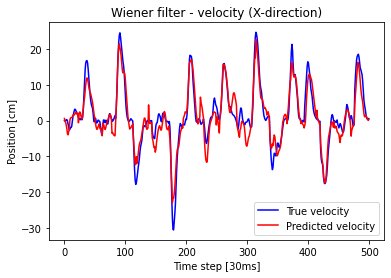

In [31]:
#As an example, I plot an example 1000 values of the x velocity (column index 0), both true and predicted with the Wiener filter
#Note that I add back in the mean value, so that both true and predicted values are in the original coordinates
fig_x_wf=plt.figure()
plt.plot(y_valid[1000:1500,0]+y_train_mean[0],'b',label="True velocity")
plt.plot(y_valid_predicted_wf[1000:1500,0]+y_train_mean[0],'r', label="Predicted velocity")
plt.title("Wiener filter - velocity (X-direction)")
plt.legend(loc="best")
plt.xlabel("Time step [30ms]")
plt.ylabel("Position [cm]")
#plt.savefig('Figures/Actual/WF_vel_X.eps', format='eps')
#plt.savefig('Figures/Actual/WF_vel_X.png')
plt.show()

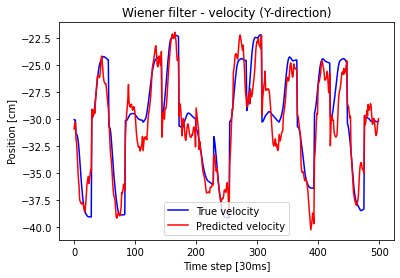

In [39]:
#As an example, I plot an example 1000 values of the x velocity (column index 0), both true and predicted with the Wiener filter
#Note that I add back in the mean value, so that both true and predicted values are in the original coordinates
fig_x_wf=plt.figure()
plt.plot(y_valid[1000:1500,1]+y_train_mean[1],'b',label="True velocity")
plt.plot(y_valid_predicted_wf[1000:1500,1]+y_train_mean[1],'r', label="Predicted velocity")
plt.title("Wiener filter - velocity (Y-direction)")
plt.legend(loc="best")
plt.xlabel("Time step [30ms]")
plt.ylabel("Position [cm]")
#plt.savefig('Figures/Actual/WF_vel_Y.eps', format='eps')
#plt.savefig('Figures/Actual/WF_vel_Y.png')
plt.show()

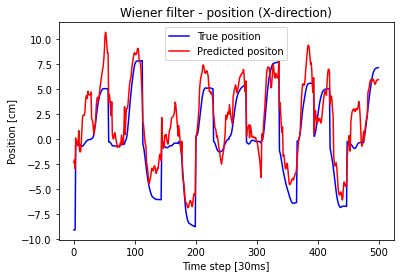

In [42]:
#As an example, I plot an example 1000 values of the x velocity (column index 0), both true and predicted with the Wiener filter
#Note that I add back in the mean value, so that both true and predicted values are in the original coordinates
fig_x_wf=plt.figure()
plt.plot(y_valid[1000:1500,0]+y_train_mean[0],'b',label="True position")
plt.plot(y_valid_predicted_wf[1000:1500,0]+y_train_mean[0],'r', label="Predicted positon")
plt.title("Wiener filter - position (X-direction)")
plt.legend(loc="best")
plt.xlabel("Time step [30ms]")
plt.ylabel("Position [cm]")
#plt.savefig('Figures/Actual/WF_pos_X.eps', format='eps')
#plt.savefig('Figures/Actual/WF_pos_X.png')
plt.show()

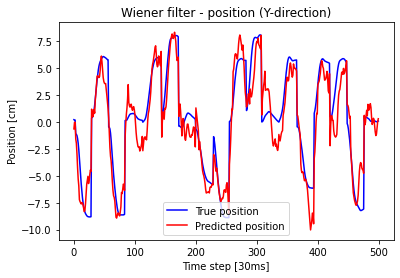

In [43]:
fig_x_wf=plt.figure()
plt.plot(y_valid[1000:1500,1],'b',label="True position")
plt.plot(y_valid_predicted_wf[1000:1500,1],'r', label="Predicted position")
plt.title("Wiener filter - position (Y-direction)")
plt.legend(loc="best")
plt.xlabel("Time step [30ms]")
plt.ylabel("Position [cm]")
#plt.savefig('Figures/Actual/WF_pos_Y.eps', format='eps')
#plt.savefig('Figures/Actual/WF_pos_Y.png')
plt.show()